In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.downloader.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
# nltk.download('wordnet')

In [2]:
# import data
raw_data =  pd.read_csv('../raw-data/skills_test.csv')

In [3]:
# have a look at some text
raw_data['Text'].head()

0    I bought a car through a dealership and had so...
1    April 7, 2006 Wells Fargo Bank announced they ...
2    Securities watchdog investigates Wells Fargo o...
3    I had a problem where for months my student lo...
4    If someone opens a bank account without your k...
Name: Text, dtype: object

In [4]:
def clean_text(s):
    """
    Pre-process text data by removing stop words, puncuation and strange characters
    
    return string
    """
    lemma = WordNetLemmatizer()
    porter = PorterStemmer()
    symbols_re = re.compile('[^a-z #+_]')
    space_re = re.compile('[/(){}\[\]\|@,;]')
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.lower()
    s = symbols_re.sub('', s)
    s = space_re.sub(' ', s)
    s = ' '.join([l for l in s.split() if l not in stopwords.words('english')])
    normalized = " ".join(lemma.lemmatize(word) for word in s.split())
    stemmed = [porter.stem(word) for word in normalized.split()]
    return stemmed

In [5]:
raw_data['Text'] = raw_data['Text'].apply(clean_text)

In [6]:
sents = raw_data['Text'].apply(lambda x: ' '.join(x))

## Frequent terms

In [7]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=None, stop_words = 'english' )
vectorizer.fit(sents)
vect_sentences  = vectorizer.transform(sents)
sum_words = vect_sentences.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words = sorted(words_freq, key=lambda x: x[1])

In [8]:
label = [l[0] for l in words[-30:]]
value = [v[1] for v in words[-30:]]

Text(0.5, 1.0, 'Number of unigrams in text')

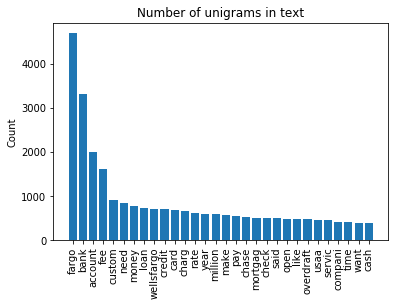

In [9]:
plt.bar(label[::-1],value[::-1])
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of unigrams in text')
# plt.ylim([150,])

In [10]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=None, stop_words = 'english' )
vectorizer.fit(sents)
vect_sentences  = vectorizer.transform(sents)
sum_words = vect_sentences.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words = sorted(words_freq, key=lambda x: x[1])

In [11]:
label = [l[0] for l in words[-30:]]
value = [v[1] for v in words[-30:]]

Text(0.5, 1.0, 'Number of bigrams in text')

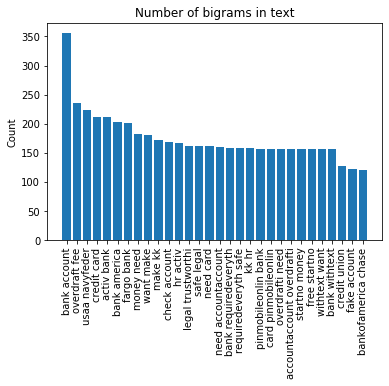

In [12]:
plt.bar(label[::-1],value[::-1])
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of bigrams in text')
# plt.ylim([150,])

In [13]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(3, 3), max_features=None, stop_words = 'english' )
vectorizer.fit(sents)
vect_sentences  = vectorizer.transform(sents)
sum_words = vect_sentences.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words = sorted(words_freq, key=lambda x: x[1])

In [14]:
label = [l[0] for l in words[-30:]]
value = [v[1] for v in words[-30:]]

Text(0.5, 1.0, 'Number of trigrams in text')

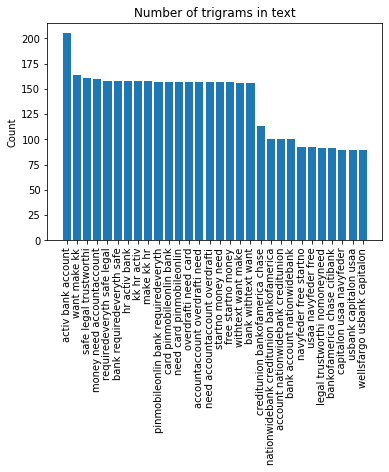

In [15]:
plt.bar(label[::-1],value[::-1])
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of trigrams in text')
# plt.ylim([150,])

## Sentiment analysis

In [16]:
sia = SentimentIntensityAnalyzer()

In [17]:
collected_sentiment = sents.apply(lambda x: sia.polarity_scores(x))

In [18]:
raw_data['sentiment'] = collected_sentiment.apply(lambda x: x['compound'])

(array([115., 171., 156., 230., 398., 217., 651., 462., 548., 880.]),
 array([-0.9838 , -0.78577, -0.58774, -0.38971, -0.19168,  0.00635,
         0.20438,  0.40241,  0.60044,  0.79847,  0.9965 ]),
 <a list of 10 Patch objects>)

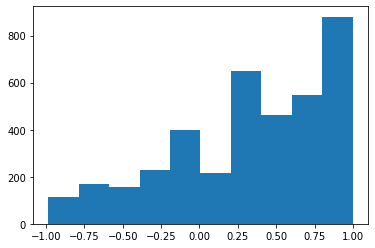

In [19]:
plt.hist(collected_sentiment.apply(lambda x: x['compound']))

In [20]:
sia.polarity_scores(
    "I took my accts out of Wells Fargo a year ago.  I deal w a credit union now.  I'm very happy...much fairer fees too.")

{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.5574}

## Topic Extraction

In [21]:
no_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(sents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [22]:
lda = LatentDirichletAllocation(n_components=10,
                                max_iter=5, 
                                random_state=0).fit(tf)

In [23]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
wellsfargo billion busi fargo hold googl manag rt help thank
Topic 1:
fargo bank custom account million fee charg said lawsuit cash
Topic 2:
fargo loan fee rate account credit payment xxxx pay year
Topic 3:
fargo ceo stumpf john rt warren senat million card year
Topic 4:
fargo rt wellsfargo bank april tag th citi divest financ
Topic 5:
bank usaa chase need fee seriou overdraft im harrisbank cash
Topic 6:
bank mortgag rate fargo borrow freeband financi getfreemoneynow bancorpsouth deltacommunitycreditunion
Topic 7:
bank need account money activ wellsfargo make chase usaa want
Topic 8:
fargo account fee check servic charg card custom bank open
Topic 9:
fargo bank compani like said year busi board im market


In [24]:
x = raw_data['Text']
y = raw_data['label']
text_train, text_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

## K-means

In [25]:
document = [T for T in sents]

In [26]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(document)

In [27]:
true_k = 6
clf = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
data = clf.fit(X)
centroids = clf.cluster_centers_

In [28]:
print("Top terms per cluster:")
order_centroids = clf.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
print("\n")

Top terms per cluster:
Cluster 0:
 fargo
 bank
 account
 fee
 custom
 charg
 credit
 rate
 year
 loan
Cluster 1:
 loan
 auto
 car
 credit
 bad
 refin
 rate
 refinanc
 financ
 bank
Cluster 2:
 bank
 need
 usaa
 chase
 account
 citibank
 creditunion
 navyfeder
 wellsfargo
 usbank
Cluster 3:
 kirkendol
 googl
 hold
 manag
 rci
 hospit
 tap
 llc
 imag
 owner
Cluster 4:
 buy
 home
 hous
 step
 time
 process
 afford
 daunt
 guid
 credit
Cluster 5:
 cash
 app
 squar
 appsquar
 cardsquar
 codesquar
 moneysquar
 appl
 send
 sign




In [29]:
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 0

In [30]:
model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

In [ ]:
# transformed_centroids = model.fit_transform(centroids)
transformed_words = model.fit_transform(X.toarray())

In [ ]:
true_k = 1
clf = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
data = clf.fit(transformed_words)
centroids = clf.cluster_centers_
y_kmeans = clf.predict(transformed_words)

In [ ]:
centers = clf.cluster_centers_

In [ ]:
print(transformed_centroids)
# plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
plt.scatter(transformed_words[:, 0], transformed_words[:, 1], marker='o', c=y_kmeans)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
# plot individual data points
plt.show()